<a href="https://colab.research.google.com/github/anaguilarar/agwise_data_sourcing/blob/main/GEEMODIS_data_download.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ag-Wise Data Sourcing

## MODIS/VIIRS Vegetation Index Time Series Downloader

This tutorial explains how to use this notebook to download, process, and visualize vegetation index (VI) time series (e.g., NDVI) from MODIS or VIIRS using Google Earth Engine (GEE).

Firs you need to clone the repository

In [ ]:
import os

if not os.path.exists('agwise_data_sourcing'):
  !git clone https://github.com/anaguilarar/agwise_data_sourcing.git
  os.chdir('/content/agwise_data_sourcing')
else:
  os.chdir('/content/agwise_data_sourcing')

## Workflow Overview
1. **Country Example Configuration** – Select area, time, and satellite product.
2. **Data Downloading** – Retrieve NDVI time series using GEE.
3. **Data Preprocessing** – Fill gaps and smooth temporal noise.
4. **Crop Masking** – Focus analysis on cropland areas.
5. **Crop mask visualization** – NDVI spatial differences.

### Country Example Configuration


In this section, you will set the parameters for your analysis. Modify the dictionary below to match your region and product of interest.


- `ADM0_NAME` define the administrative levels.
- `product` sets the MODIS/VIIRS dataset.
- `starting_date` and `ending_date` specify the period of interest.


Example: NDVI extraction for **Kenya – Coast Province (2023)**

In [6]:

### INITIAL configuration

configuration = {
    'GENERAL_SETTINGS':{
      'ee_project_name': 'ee-anaguilarar',
      'output_path': 'runs'

      },
    'PREPROCESSING':{
        'data_filling': True,
        'sg_smoothing': True,
        'sg_window': 3,
        'crop_mask': True,
        'crop_mask_product': 'ESA'
    },
    'DATA_DOWNLOAD':
     {
      'ADM0_NAME': 'Kenya',
      'ADM1_NAME': 'Kakamega',
      'ADM2_NAME': None,
      'product': 'MOD13Q1',
      'starting_date': '2023-01-01',
      'ending_date': '2023-12-31',
      'scale': 250,
      'adm_level' : 'ADM1'

    }
}


- The first time you run this notebook, GEE will request authentication (`ee.Authenticate()`).
- Depending on your area size, the data request might take a few minutes.

In [2]:
from gee_datasets.modis import GEEMODIS
import ee
ee.Initialize(project=configuration['GENERAL_SETTINGS']['ee_project_name'])


### Data Downloading


This section connects to Google Earth Engine, defines your region of interest, and retrieves the vegetation index time series.


Steps:
1. **Initialize Google Earth Engine (GEE)** with your project.
2. **Create the downloader object** (`GEEMODIS`).
3. **Run the query** to retrieve the imagery.

In [3]:
data_downloader = GEEMODIS(configuration['DATA_DOWNLOAD']['ADM0_NAME'], configuration['DATA_DOWNLOAD']['product'])
data_downloader.initialize_query(configuration['DATA_DOWNLOAD']['starting_date'], configuration['DATA_DOWNLOAD']['ending_date'])


[{'type': 'Feature', 'geometry': None, 'id': '2023_01_01', 'properties': {'NDVI': 3399.1486780787563, 'date': '2023-01-01T00:00:00'}}, {'type': 'Feature', 'geometry': None, 'id': '2023_01_17', 'properties': {'NDVI': 3191.4627656399844, 'date': '2023-01-17T00:00:00'}}, {'type': 'Feature', 'geometry': None, 'id': '2023_02_02', 'properties': {'NDVI': 2829.804555013558, 'date': '2023-02-02T00:00:00'}}, {'type': 'Feature', 'geometry': None, 'id': '2023_02_18', 'properties': {'NDVI': 2700.169533737635, 'date': '2023-02-18T00:00:00'}}, {'type': 'Feature', 'geometry': None, 'id': '2023_03_06', 'properties': {'NDVI': 2645.9907473710755, 'date': '2023-03-06T00:00:00'}}, {'type': 'Feature', 'geometry': None, 'id': '2023_03_22', 'properties': {'NDVI': 3413.349533055135, 'date': '2023-03-22T00:00:00'}}, {'type': 'Feature', 'geometry': None, 'id': '2023_04_07', 'properties': {'NDVI': 4451.494989720907, 'date': '2023-04-07T00:00:00'}}, {'type': 'Feature', 'geometry': None, 'id': '2023_04_23', 'proper

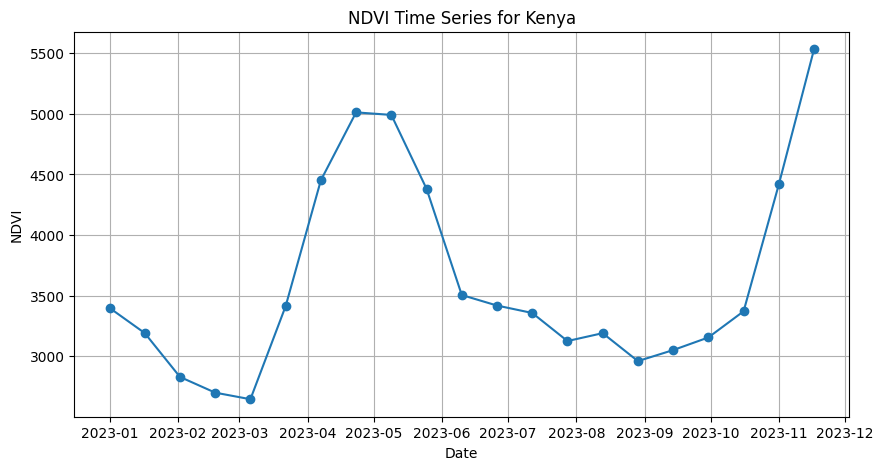

,date,NDVI
0,2023-01-01,3399.148678
1,2023-01-17,3191.462766
2,2023-02-02,2829.804555
3,2023-02-18,2700.169534
4,2023-03-06,2645.990747
5,2023-03-22,3413.349533
6,2023-04-07,4451.494990
7,2023-04-23,5011.517496
8,2023-05-09,4990.488823
9,2023-05-25,4381.384597


In [4]:
data_downloader.plot_time_series('NDVI')

### Data Preprocessing


Once you have the raw NDVI time series, you can apply two important steps to make it analysis-ready:


1. **Gap Filling**: Handles missing data due to cloud cover or sensor issues using linear interpolation.
2. **Smoothing**: Applies the Savitzky–Golay filter to reduce noise while preserving vegetation dynamics.



In [5]:
from gee_datasets.processing_funs import fill_gaps_linear, smooth_ts_using_savitsky_golay_modis, summarize_collection_tots
import matplotlib.pyplot as plt

data_filled = fill_gaps_linear(data_downloader.query, 'NDVI')

print("First smoothed image properties:",
      ee.Image(data_filled.first()).getInfo()["properties"])



First smoothed image properties: {'system:time_start': 1672531200000, 'google:max_source_file_timestamp': 1674237758000, 'num_tiles': 286, 'system:footprint': {'type': 'LinearRing', 'coordinates': [[-180, -90], [180, -90], [180, 90], [-180, 90], [-180, -90]]}, 'system:time_end': 1673913600000, 'system:asset_size': 29616439319, 'system:index': '2023_01_01'}


In [6]:
band = 'NDVI'
result = smooth_ts_using_savitsky_golay_modis(data_filled.select('NDVI'), window_size = 5)
print("First smoothed image properties:",
      ee.Image(result.first()).getInfo()["properties"])


First smoothed image properties: {'system:time_start': 1675296000000, 'system:index': '0'}


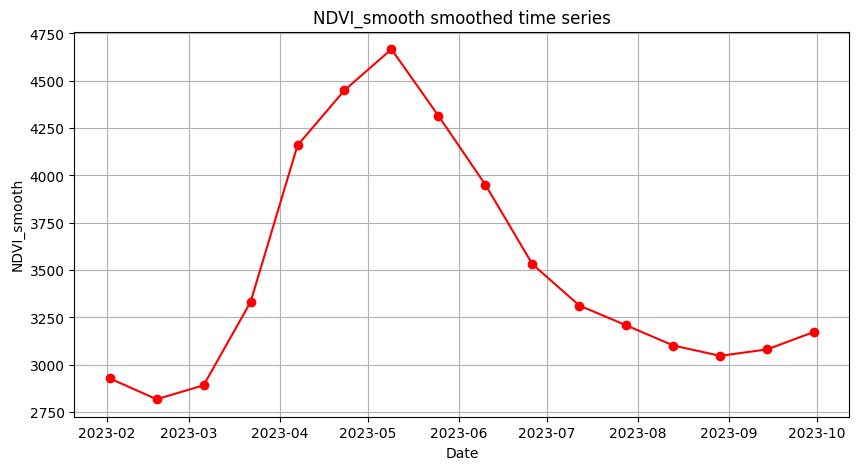

In [7]:
from utils.plots import plot_time_series_from_ic

band2 = 'NDVI_smooth'

df = plot_time_series_from_ic(
    ic=ee.ImageCollection(result),
    band=band2,
    summarize_fn=summarize_collection_tots,
    region_filter=data_downloader.country_filter,
    title=f"{band2} smoothed time series"
)


### Download data for a specific administrative level

You can target data at different administrative levels using the configuration keys:

1. Set `ADM0_NAME` for the country (required).
2. Set `ADM1_NAME` for the first-level admin (province/state) if you want a subregion.
3. Set `ADM2_NAME` for the district/municipality if available and needed.


**Example configuration (Kenya, Coast province):**


```python
configuration['DATA_DOWNLOAD'].update({
'ADM0_NAME': 'Kenya',
'ADM1_NAME': 'Kakamega',
'ADM2_NAME': None,

})


In [13]:
data_downloader = GEEMODIS(configuration['DATA_DOWNLOAD']['ADM0_NAME'], configuration['DATA_DOWNLOAD']['product'])
data_downloader.initialize_query(configuration['DATA_DOWNLOAD']['starting_date'], configuration['DATA_DOWNLOAD']['ending_date'])

feature_name = 'Kakamega'

not_smootheddf = data_downloader.get_adm_timeseries(adm_level='ADM1', feature_name= feature_name, fill_gaps=True, sg = False)
smootheddf3 = data_downloader.get_adm_timeseries(adm_level='ADM1', feature_name= feature_name, fill_gaps=True, sg = True, window_size = 3)
smootheddf5 = data_downloader.get_adm_timeseries(adm_level='ADM1', feature_name= feature_name, fill_gaps=True, sg = True, window_size = 5)

data will be processed for: Kakamega
data will be processed for: Kakamega
data will be processed for: Kakamega


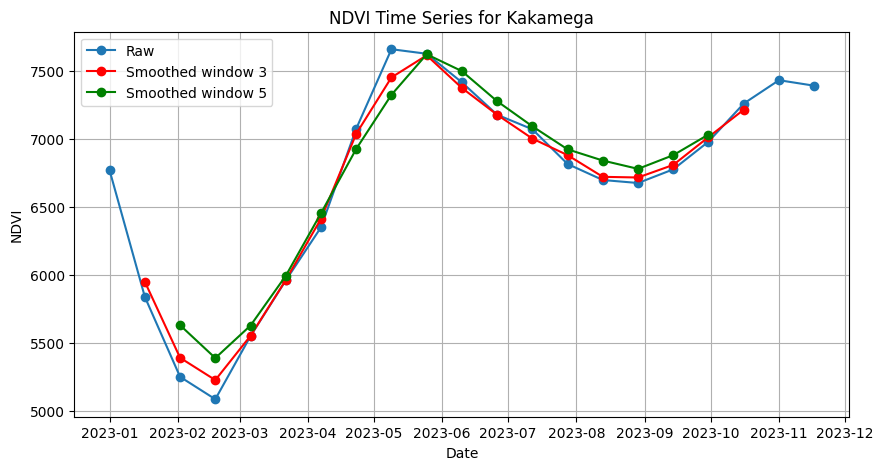

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(not_smootheddf['date'], not_smootheddf[not_smootheddf.columns[1]], marker='o', linestyle='-', label = 'Raw')
plt.plot(smootheddf3['date'], smootheddf3[smootheddf3.columns[1]], marker='o', linestyle='-', c = 'red', label = 'Smoothed window 3')
plt.plot(smootheddf5['date'], smootheddf5[smootheddf5.columns[1]], marker='o', linestyle='-', c = 'green', label = 'Smoothed window 5')

plt.title(f"{not_smootheddf.columns[1]} Time Series for {feature_name}")
plt.xlabel("Date")
plt.ylabel(not_smootheddf.columns[1])
plt.grid(True)
plt.legend()
plt.show()

### Using a Crop Mask


Crop masking helps you focus only on agricultural areas, avoiding urban or forest regions.


You can enable it in the configuration dictionary:
```python
'PREPROCESSING': {
'crop_mask': True,
'crop_mask_product': 'ESA' # or 'DYNAMICWORLD'
}
```


- **ESA WorldCover (ESA)** provides global land cover classes.
- **Dynamic World (Google)** offers near real-time land classification.


When enabled, the notebook filters the NDVI collection to cropland pixels only.

In [3]:
from gee_datasets.gee_data import GEECropMask
from gee_datasets.modis import GEEMODIS


data_downloader = GEEMODIS(configuration['DATA_DOWNLOAD']['ADM0_NAME'], configuration['DATA_DOWNLOAD']['product'])
data_downloader.initialize_query(configuration['DATA_DOWNLOAD']['starting_date'], configuration['DATA_DOWNLOAD']['ending_date'])


cropmask_downloader = GEECropMask(configuration['DATA_DOWNLOAD']['ADM0_NAME'], configuration['PREPROCESSING']['crop_mask_product'])
cropmask_downloader.initialize_query()

crop_mask = ee.Image(cropmask_downloader.query.first()).clip(cropmask_downloader.country_filter).eq(cropmask_downloader.crop_mask_value[cropmask_downloader.product])



### Crop mask visualization
Visualization of raw vs. processed imagery


In [ ]:
from gee_datasets.processing_funs import fill_gaps_linear, smooth_ts_using_savitsky_golay_modis

data_filled = fill_gaps_linear(data_downloader.query, 'NDVI')


datamasked = data_downloader.query.first().clip(cropmask_downloader.country_filter).updateMask(crop_mask)

data_filled_masked = data_filled.first().clip(cropmask_downloader.country_filter).updateMask(crop_mask)

data_filled_SG = smooth_ts_using_savitsky_golay_modis(data_filled.select('NDVI'), window_size = 5)


data_filled_SG_masked = data_filled_SG.first().clip(cropmask_downloader.country_filter).updateMask(crop_mask)

### Download spatial data for a specific administrative level

In [7]:

from gee_datasets.gee_data import GEECropMask
from gee_datasets.modis import GEEMODIS
import os

data_downloader = GEEMODIS(configuration['DATA_DOWNLOAD']['ADM0_NAME'], configuration['DATA_DOWNLOAD']['product'])
data_downloader.initialize_query(configuration['DATA_DOWNLOAD']['starting_date'], configuration['DATA_DOWNLOAD']['ending_date'])


cropmask_downloader = GEECropMask(configuration['DATA_DOWNLOAD']['ADM0_NAME'], configuration['PREPROCESSING']['crop_mask_product'])
cropmask_downloader.initialize_query()

crop_mask = ee.Image(cropmask_downloader.query.first()).clip(cropmask_downloader.country_filter).eq(cropmask_downloader.crop_mask_value[cropmask_downloader.product])

img_collection = data_downloader.get_adm_level_data(adm_level= 'ADM1', feature_name=configuration['DATA_DOWNLOAD']['ADM1_NAME'],  band = 'NDVI', fill_data = True, smooth_data = True, crop_mask = crop_mask, adm_filter = None, window_size = 3)
output_tmpdir = os.path.join(configuration['GENERAL_SETTINGS']['output_path'], configuration['DATA_DOWNLOAD']['ADM1_NAME'].lower())
scale = configuration['DATA_DOWNLOAD']['scale']
data_downloader.download_data(img_collection, output_dir= output_tmpdir, feature_geometry = data_downloader._adm_filter.geometry(), scale = scale, img_property = 'system:id')



data will be processed for: Kakamega
Image saved in runs\kakamega\Kenya_NDVI_2023_017.tif
Image saved in runs\kakamega\Kenya_NDVI_2023_033.tif
Image saved in runs\kakamega\Kenya_NDVI_2023_049.tif
Image saved in runs\kakamega\Kenya_NDVI_2023_065.tif
Image saved in runs\kakamega\Kenya_NDVI_2023_081.tif
Image saved in runs\kakamega\Kenya_NDVI_2023_097.tif
Image saved in runs\kakamega\Kenya_NDVI_2023_113.tif
Image saved in runs\kakamega\Kenya_NDVI_2023_129.tif
Image saved in runs\kakamega\Kenya_NDVI_2023_145.tif
Image saved in runs\kakamega\Kenya_NDVI_2023_161.tif
Image saved in runs\kakamega\Kenya_NDVI_2023_177.tif
Image saved in runs\kakamega\Kenya_NDVI_2023_193.tif
Image saved in runs\kakamega\Kenya_NDVI_2023_209.tif
Image saved in runs\kakamega\Kenya_NDVI_2023_225.tif
Image saved in runs\kakamega\Kenya_NDVI_2023_241.tif
Image saved in runs\kakamega\Kenya_NDVI_2023_257.tif
Image saved in runs\kakamega\Kenya_NDVI_2023_273.tif
Image saved in runs\kakamega\Kenya_NDVI_2023_289.tif
Image sav

### Create Datacube

In [ ]:
!pip install rioxarray

In [8]:

import xarray
import rioxarray as rio
import os
raster_list = [os.path.join('modis',i) for i in os.listdir('modis') if i.endswith('tif')]
band_name, xrdata_list = [], []

for i in range(len(raster_list)):
    xrdata = rio.open_rasterio(raster_list[i])
    band_name.append(os.path.basename(raster_list[i])[:-4])
    xrdata_list.append(xrdata)
    
xrstacked = xarray.concat(xrdata_list, dim = 'band')

xrstacked = xrstacked.assign_coords({'band': band_name})

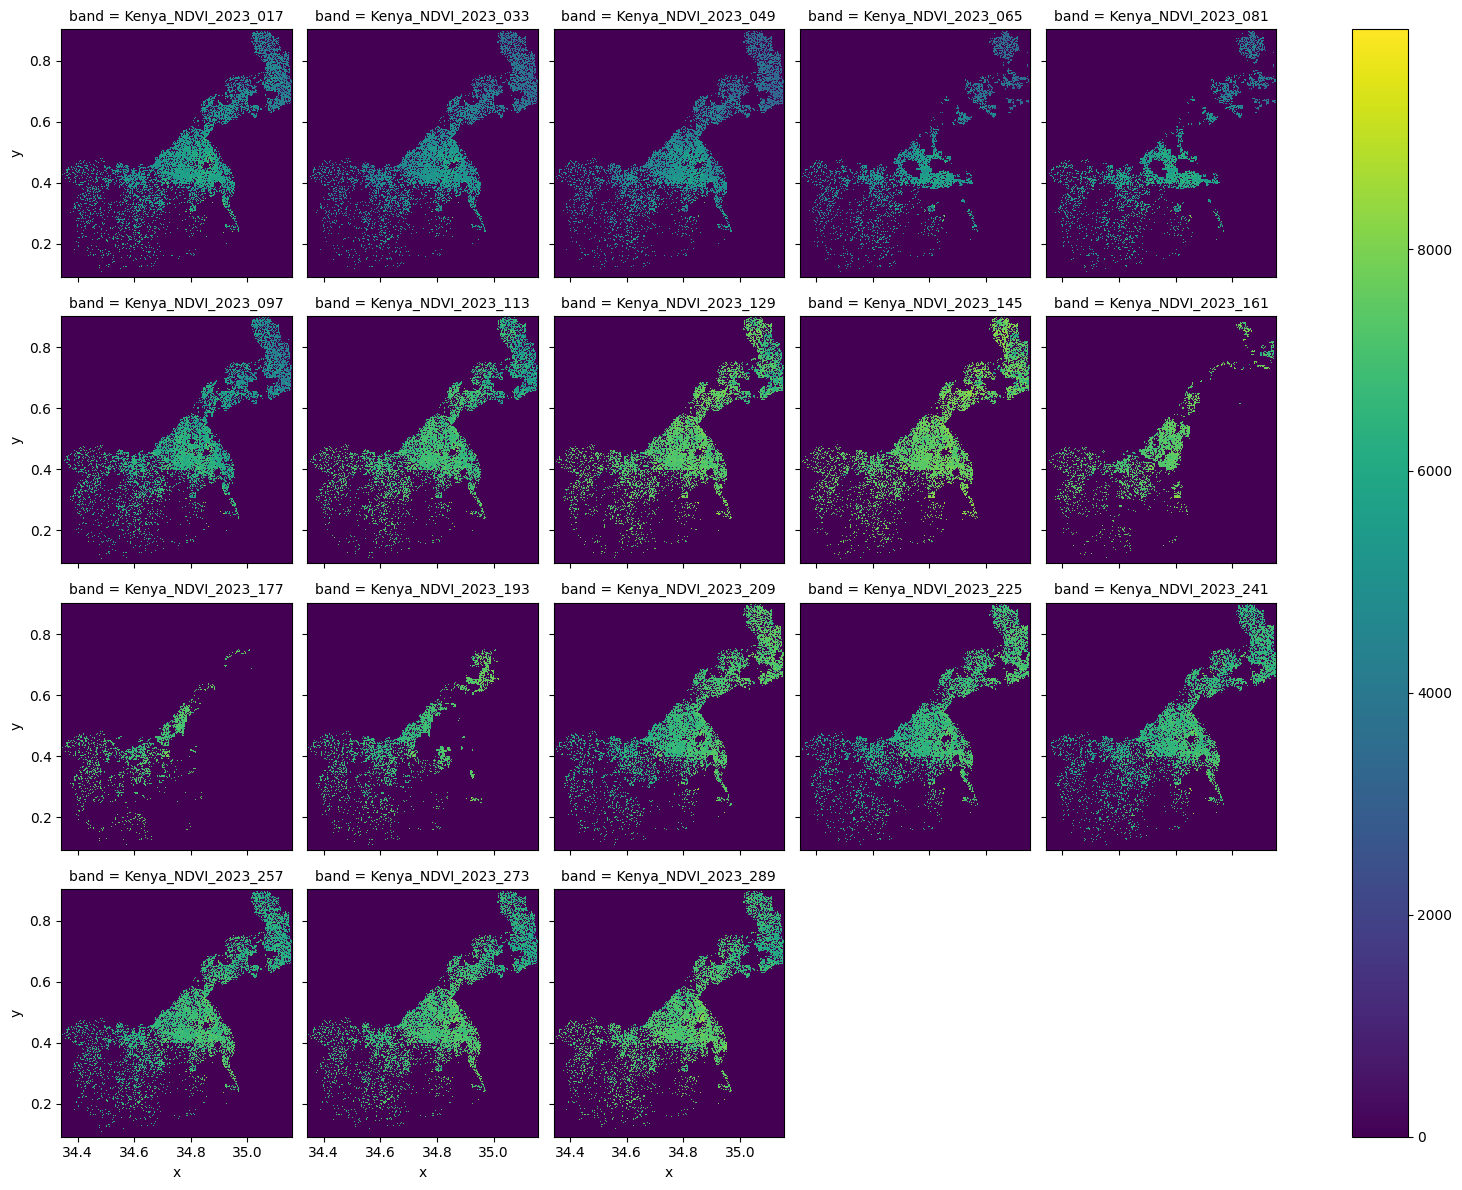

In [17]:
grid = xrstacked.plot(col = 'band', col_wrap=5)
grid.fig.savefig('runs/imgs.png')

In [ ]:
from datetime import datetime

usecase = None
init_date = configuration['DATA_DOWNLOAD']['starting_date']
end_date = configuration['DATA_DOWNLOAD']['ending_date']

init_year = datetime.strptime(init_date, '%Y-%m-%d').year
ending_year = datetime.strptime(end_date, '%Y-%m-%d').year

if not usecase:
    usecase = configuration['DATA_DOWNLOAD']['ADM1_NAME'].title()
    
output_fn = '{country}_{usecase}_MODIS_NDVI_{init_year}_{ending_year}_{sg}.tif'.format(
    country = data_downloader.country.title(),
    usecase = usecase,
    init_year = init_year,
    ending_year = ending_year,
    sg = 'SG' if configuration['PREPROCESSING']['sg_smoothing'] else '')


xrstacked = xrstacked.assign_attrs(band_names=xrstacked.band.values.tolist())

xrstacked.rio.to_raster(os.path.join(output_tmpdir, output_fn))

In [12]:
rio.open_rasterio(os.path.join(output_tmpdir, output_fn))

<xarray.DataArray (band: 18, y: 361, x: 362)> Size: 19MB
[2352276 values with dtype=float64]
Coordinates:
  * band         (band) int64 144B 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18
  * x            (x) float64 3kB 34.34 34.35 34.35 34.35 ... 35.15 35.15 35.15
  * y            (y) float64 3kB 0.9017 0.8994 0.8972 ... 0.09769 0.09545 0.0932
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    band_names:              ['Kenya_NDVI_2023_017', 'Kenya_NDVI_2023_033', '...
    AREA_OR_POINT:           Area
    _FillValue:              0.0
    scale_factor:            1.0
    add_offset:              0.0

### Using the configuration file in terminal

In [ ]:
import os

if os.path.exists('/content/agwise_data_sourcing'):
    os.chdir('/content/agwise_data_sourcing')

!python download_modis.py -config yaml_configurations/modis_data_download.yaml

^C


      
            |                                      |
            |         AGWISE DATA SOURCING         |    
            |               GEEMODIS               |
            |                                      |
      
yaml_configurations/modis_data_download.yaml
-------> Starting:  yaml_configurations/modis_data_download.yaml
data will be processed for: Kakamega
Image saved in runs\kakamega\Kenya_NDVI_2022_177.tif
Image saved in runs\kakamega\Kenya_NDVI_2022_193.tif
Image saved in runs\kakamega\Kenya_NDVI_2022_209.tif
Image saved in runs\kakamega\Kenya_NDVI_2022_225.tif
Image saved in runs\kakamega\Kenya_NDVI_2022_241.tif
Image saved in runs\kakamega\Kenya_NDVI_2022_257.tif
Image saved in runs\kakamega\Kenya_NDVI_2022_273.tif
Image saved in runs\kakamega\Kenya_NDVI_2022_289.tif
Image saved in runs\kakamega\Kenya_NDVI_2022_305.tif
Image saved in runs\kakamega\Kenya_NDVI_2022_321.tif
Image saved in runs\kakamega\Kenya_NDVI_2022_337.tif
Image saved in runs\kakamega\Kenya_NDVI_

Traceback (most recent call last):
  File "d:\OneDrive - CGIAR\scripts\agwise_data_sourcing\download_modis.py", line 131, in <module>
    main(config)
  File "d:\OneDrive - CGIAR\scripts\agwise_data_sourcing\download_modis.py", line 115, in main
    for i in raster_list: os.remove(i)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'runs\\kakamega\\Kenya_NDVI_2022_177.tif'
